### Ajuste de parámetros mediante validación cruzada

Imports:

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from time import time
import shutil

Carga de datos, MNIST:

In [7]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [8]:
mean_img = train_images.mean(axis=0)
train_images = train_images - mean_img
test_images = test_images - mean_img

Reduzco mucho el tamaño del conjunto de entrenamiento, para que las pruebas vayan más rápido:

In [9]:
# Numero de ejemplos para entrenamiento
num_train = 5000

# Seleccionamos imagenes para training
tr_images = train_images[:num_train]
tr_labels = train_labels[:num_train]
print(tr_images.shape)
print(tr_labels.shape)

(5000, 28, 28)
(5000,)


Validación de un modelo:

Usamos la clase ``StratifiedKFold`` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) de ``scikitlearn``, que genera índices para entrenamiento y validación de acuerdo a una estrategia de validación cruzada con k folds.

En el siguiente ejemplo se usa ``k = 5``:


In [5]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)
# kfold.split(...) devuelve un generador que genera los índices de entrenamiento
# y test para cada una de las particiones

cvscores = []
for itrain, itest in kfold.split(tr_images, tr_labels):
    # Creamos el modelo:
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1.0)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    # Lo compilamos:
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    # Lo entrenamos:
    nepochs = 30
    history = model.fit(tr_images[itrain],
                        tr_labels[itrain],
                        epochs=nepochs,
                        verbose=0,
                        batch_size=50)

    # Lo evaluamos:
    loss, acc = model.evaluate(tr_images[itest], tr_labels[itest], verbose=0)

    print("Accuracy: %.2f%%" % (acc*100.0))
    cvscores.append(acc * 100.)
print("%.2f%% \u00B1 %.2f%%" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 91.20%
Accuracy: 90.80%
Accuracy: 89.10%
Accuracy: 87.80%
Accuracy: 88.70%
89.52% ± 1.29%


A continuación definimos algunas funciones para simplificar la tarea.

Esta función crea una red neuronal con ``nhidden`` neuronas ocultas y constante de regularización ``lreg``:

In [6]:
def create_model(nhidden, lreg):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

Esta función evalúa un modelo haciendo validación cruzada:

In [7]:
def xvalidation(x, y, nhidden, lreg, lrate, num_epochs, bsize, nfolds, semilla):

    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=semilla)
    cvscores = np.zeros(nfolds)
    for i, (train, test) in enumerate(kfold.split(x, y)):
        model = create_model(nhidden, lreg)
        model.compile(optimizer=keras.optimizers.Adam(lrate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])

        history = model.fit(x[train],
                            y[train],
                            epochs=num_epochs,
                            verbose=0,
                            batch_size=bsize)

        loss, acc = model.evaluate(x[test], y[test], verbose=0)

        cvscores[i] = acc
    return cvscores

En la función anterior, ¿por qué se crea el ``StratifiedKFold`` pasando como argumento ``random_state=semilla``?

Búsqueda del número de neuronas y la constante de regularización:

In [8]:
for nhidden in [32, 64]:
  for lreg in [1.0, 0.1, 0.01, 0.001]:
      cvscores = xvalidation(tr_images, tr_labels, nhidden, lreg, 0.001, 30, 50, 5, 13)
      print("nhidden = %d" % (nhidden))
      print("lreg = %f" % (lreg))
      print(cvscores)
      print("   %.2f%% \u00B1 %.2f%%" % (100*np.mean(cvscores), 100*np.std(cvscores)))

nhidden = 32
lreg = 1.000000
[0.903      0.89600003 0.89300001 0.89700001 0.90200001]
   89.82% ± 0.38%
nhidden = 32
lreg = 0.100000
[0.92000002 0.903      0.88599998 0.91500002 0.917     ]
   90.82% ± 1.25%
nhidden = 32
lreg = 0.010000
[0.91299999 0.90799999 0.88999999 0.91500002 0.89999998]
   90.52% ± 0.92%
nhidden = 32
lreg = 0.001000
[0.903      0.89999998 0.88599998 0.91600001 0.90799999]
   90.26% ± 0.99%
nhidden = 64
lreg = 1.000000
[0.90499997 0.912      0.86400002 0.89999998 0.89899999]
   89.60% ± 1.66%
nhidden = 64
lreg = 0.100000
[0.93400002 0.91799998 0.91000003 0.92500001 0.92400002]
   92.22% ± 0.80%
nhidden = 64
lreg = 0.010000
[0.92500001 0.91600001 0.90899998 0.92500001 0.90399998]
   91.58% ± 0.84%
nhidden = 64
lreg = 0.001000
[0.93000001 0.91399997 0.89099997 0.921      0.91500002]
   91.42% ± 1.29%


Elegimos los mejores parámetros de acuerdo a la búsqueda anterior y volvemos a entrenar el modelo con esos parámetros usando todos los datos de entrenamiento:

In [10]:
nhidden = 64
lreg = 0.1

model = create_model(nhidden, lreg)

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(tr_images,
                    tr_labels,
                    epochs=30,
                    verbose=0,
                    batch_size=50)

Y lo aplicamos a los datos de test:

In [11]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print(acc)

0.9120000004768372


**Otras métricas:** ¿Cómo calcular, por ejemplo el ROC-AUC?

Como ejemplo, calculemos la ROC para una de las clases frente al resto:

313/313 [==============================] - 1s 2ms/step


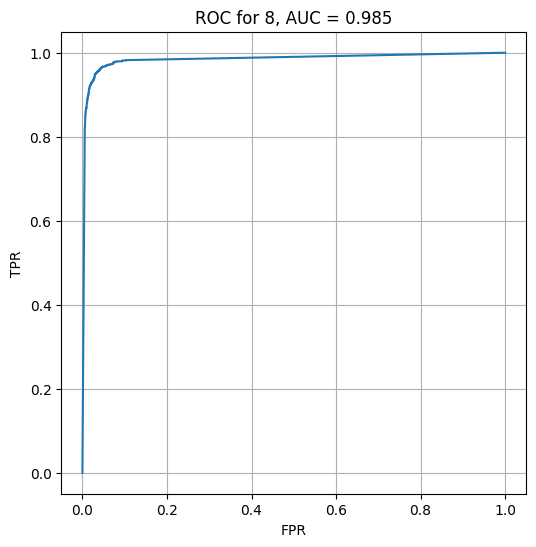

In [12]:
from sklearn import metrics

target = 8
probs = model.predict(test_images)
prob_target = probs[:, target]
ytrue = test_labels == target

fpr, tpr, thresholds = metrics.roc_curve(ytrue, prob_target, pos_label=1)
auc = metrics.roc_auc_score(ytrue, prob_target)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC for {target}, AUC = {auc:.3f}')
plt.grid(True)
plt.show()

**Ejercicio:** Realizar una validación cruzada utilizando una métrica de evaluación distinta.

Cómo hacer todo esto de una manera más automática:

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de ``scikit-learn``.

- Keras Tuner: https://www.tensorflow.org/tutorials/keras/keras_tuner

- HParams dashboard en tensorboard: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

### Ejemplo de uso de GridSearchCV:

Usamos ``scikeras``, un wrapper de keras para ``scikit-learn``.

In [1]:
!pip install scikeras

In [2]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

Función para crear el modelo. Devuelve el modelo ya compilado:

In [12]:
def create_model(nhidden, lreg, lrate):
    model = keras.Sequential()
    model.add(keras.layers.Input((28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(lrate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

Usamos la clase [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) para adaptar el modelo al estilo de ``scikit-learn``:

In [13]:
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

Ahora podemos usar los métodos típicos de ``scikit-learn``, como ``fit``, ``predict``, ``predict_proba``, ``score``, etc. Por ejemplo:

In [14]:
model.fit(tr_images, tr_labels, epochs=10, batch_size=50)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5730 - loss: 106.4487
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8932 - loss: 37.8047
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9155 - loss: 22.9218
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9399 - loss: 14.2242
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9426 - loss: 9.1772
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9373 - loss: 6.5945
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9402 - loss: 4.7982
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9331 - loss: 3.8250
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9309 - loss: 3.3737
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9397 - loss: 2.8882


KerasClassifier(
	model=<function create_model at 0x7d807533ff40>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	lreg=1.0
	nhidden=50
	lrate=0.001
	class_weight=None
)

In [15]:
preds = model.predict(tr_images)
print(preds[:10])
probs = model.predict_proba(tr_images)
print(probs[:10])
score = model.score(tr_images, tr_labels)
print(score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[5 0 4 1 9 2 1 3 1 4]
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.00000000e+00 4.36975239e-34 6.12308500e-28 2.07925519e-15
  0.00000000e+00 9.99999940e-01 1.02472453e-33 5.40074735e-25
  0.00000000e+00 2.31197678e-25]
 [9.99999940e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.05580287e-15 6.57396956e-37
  9.99999940e-01 1.13436424e-29 4.92210157e-28 2.39578451e-37
  2.82939856e-33 5.14600884e-23]
 [0.00000000e+00 9.99999940e-01 2.56769419e-15 1.15357634e-13
  1.89924811e-27 9.50284469e-29 1.16718436e-30 1.14492755e-23
  9.22220345e-09 9.16276394e-32]
 [3.07444166e-37 7.12130870e-25 0.00000000e+00 1.01816191e-20
  2.45602338e-09 1.23030463e-19 9.29412301e-21 5.33238064e-22
  1.66968572e-20 9.99999940e-01]
 [2.12017789e-27 2.91080093e-28 9.79950786e-01 4.28815632e-20
  2.51508496e-35 1.73841139e-27 1.62225287e-18 3.

Y también podemos usar el modelo en un ``GridSearchCV``:

In [16]:
parameters = {'nhidden': [32, 64], 'lreg': [1.0, 0.1, 0.01, 0.001], 'lrate': [0.001]}
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

gscv = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='accuracy')
fitted_models = gscv.fit(tr_images, tr_labels, epochs=30, batch_size=50, verbose=0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━

Resumen y mejores parámetros:

In [17]:
print("Best: %f using %s" % (fitted_models.best_score_, fitted_models.best_params_))
for params, mean_score, std_score in zip(fitted_models.cv_results_['params'], fitted_models.cv_results_['mean_test_score'], fitted_models.cv_results_['std_test_score']):
    print("%f \u00B1 %f with: %r" % (mean_score, std_score, params))

Best: 0.910200 using {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 64}
0.881000 ± 0.017135 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 32}
0.879400 ± 0.019064 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 64}
0.897800 ± 0.010147 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 32}
0.905600 ± 0.013063 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 64}
0.893400 ± 0.008089 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 32}
0.908400 ± 0.016378 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 64}
0.894400 ± 0.011672 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 32}
0.910200 ± 0.007833 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 64}


### Apéndice: checkpointing y early stopping en Keras.

``ModelCheckpoint``: https://keras.io/api/callbacks/model_checkpoint/

Es un callback que sirve para salvar un modelo de Keras durante el entrenamiento, cada cierto número de épocas.

In [26]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Input((28, 28)))
model.add(keras.layers.Flatten(name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
checkpoint_filepath = 'logs/checkpoint.model.{epoch:02d}-{val_loss:.2f}.keras'
cb2 = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss")
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.8507 - loss: 8.2548 - val_acc: 0.9393 - val_loss: 1.6232
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9471 - loss: 1.1844 - val_acc: 0.9433 - val_loss: 1.1345
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.9584 - loss: 0.6565 - val_acc: 0.9504 - val_loss: 0.8765
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.9653 - loss: 0.4303 - val_acc: 0.9426 - val_loss: 0.8731
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - acc: 0.9690 - loss: 0.3307 - val_acc: 0.9566 - val_loss: 0.6844
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.9735 - loss: 0.2404 - val_acc: 0.9538 - val_loss: 0.6953
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9755 - loss: 0.2060 - val_acc: 0.9592 - val_loss: 0.6114
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9781 - loss: 0.1615 - val_acc: 0.9587 - val_loss: 0.5952
Epoch 9/20
1200/1200 ━━━━━━━━━━━━━━━━━━━

In [27]:
loaded_model = keras.models.load_model('logs/checkpoint.model.14-0.54.keras')
loaded_model.summary()
loss_test, acc_test = loaded_model.evaluate(test_images, test_labels)
print("Loss on test set = %f" % (loss_test))
print("Accuracy on test set = %f" % (acc_test))

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ entrada (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ oculta (Dense)                       │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ salida (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,892 (198.80 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9514 - loss: 0.6445
Loss on test set = 0.543612
Accuracy on test set = 0.960900


``EarlyStopping``: https://keras.io/api/callbacks/early_stopping/

Es un callback que sirve para interrumpir el entrenamiento cuando la métrica observada deja de mejorar.


In [28]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Input((28, 28)))
model.add(keras.layers.Flatten(name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
cb2 = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=2)
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images,
                    train_labels,
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - acc: 0.8498 - loss: 7.8368 - val_acc: 0.9344 - val_loss: 1.6409
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - acc: 0.9461 - loss: 1.0951 - val_acc: 0.9436 - val_loss: 1.1931
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - acc: 0.9605 - loss: 0.5903 - val_acc: 0.9526 - val_loss: 0.8860
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9649 - loss: 0.4429 - val_acc: 0.9525 - val_loss: 0.8217
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.9707 - loss: 0.3022 - val_acc: 0.9528 - val_loss: 0.7660
Epoch 6/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9735 - loss: 0.2394 - val_acc: 0.9481 - val_loss: 0.7377
Epoch 7/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9757 - loss: 0.1952 - val_acc: 0.9525 - val_loss: 0.6807
